In [1]:
##**Natural Gradient Boosting (NGBoost)** 

It is a mix probability prediction with gradient boosting. It serves to create predictive uncertainty estimations. This methodology gives you the probability distribution P(y|x) of a prediction instead in a point estimation, that allows you calculate other statistics such as median, percentiles, confidence intervals in order to asses to more information about the esimation,

## **Methodology**
This algorithm uses base (weak) learners. It takes inputs x and outputs are used to form the conditional probability. Those base learners use scikit-learn’s Decision Tree for a tree learner and Ridge regression for a linear learner.

In [2]:
# install ngboost
#!pip install ngboost
#!pip install lightgbm
#!pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from sklearn.ensemble import RandomForestRegressor
#from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import r2_score

In [20]:
# Load data
dataset = load_boston()
X, y = dataset.data, dataset.target
features = dataset.feature_names
 
SEED = 2019

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=SEED)
print('The shape of training dataset: {}'.format(X_train.shape[0]))
print('The shape of testing dataset: {}'.format(X_test.shape[0]))

The shape of training dataset: 404
The shape of testing dataset: 102


In [6]:

# Fit and predict
rf = RandomForestRegressor(n_estimators=400, random_state=SEED).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest: R2 score on testing data: {:.2f}%'.format(100 * r2_score(y_test, y_pred)))
 
# Fit and predict
#lgb = LGBMRegressor(n_estimators=400, random_state=SEED).fit(X_train, y_train)
#y_pred = lgb.predict(X_test)
#print('LightGBM: R2 score on testing data: {:.2f}%'.format(100 * r2_score(y_test, y_pred)))
 
# Fit and predict
np.random.seed(SEED)
ngb = NGBRegressor(n_estimators=400,
                   Base=default_tree_learner, Dist=Normal, Score=MLE).fit(X_train, y_train)
y_pred = ngb.predict(X_test)
print('NGBoost: R2 score on testing data: {:.2f}%'.format(100 * r2_score(y_test, y_pred)))

Random Forest: R2 score on testing data: 79.40%
[iter 0] loss=3.6582 val_loss=0.0000 scale=0.5000 norm=3.4016
[iter 100] loss=3.0912 val_loss=0.0000 scale=1.0000 norm=3.7753
[iter 200] loss=2.6952 val_loss=0.0000 scale=1.0000 norm=2.3972
[iter 300] loss=2.3684 val_loss=0.0000 scale=1.0000 norm=1.8804
NGBoost: R2 score on testing data: 79.86%


We found that NGBoost seems to compite with RF without any hiperparametrization. Now, we show how to use the distribution obtained with NGBoost that is the advantage of this methodology over others. 

In [7]:
y_pred_ngb = pd.DataFrame(ngb.predict(X_test))

## **metrics**

In [8]:
# Check the results
print('RMSE: NGBoost', round(sqrt(mean_squared_error(y_test,y_pred_ngb)),4))

RMSE: NGBoost 3.7137


In [9]:
# test Negative Log Likelihood
Y_dists = ngb.pred_dist(X_test)
test_NLL = -Y_dists.logpdf(y_test.flatten()).mean()
print('Test NLL', test_NLL)

Test NLL 2.7122353833092814


### **Parameters of the distribution**

In [10]:
obs_idx = [0,1]
dist = ngb.pred_dist(X_test[obs_idx, :])
print('P(y_0|x_0) is normally distributed with loc={:.2f} and scale={:.2f}'.format(dist.loc[0], dist.scale[0]))
print('P(y_1|x_1) is normally distributed with loc={:.2f} and scale={:.2f}'.format(dist.loc[1], dist.scale[1]))

P(y_0|x_0) is normally distributed with loc=17.54 and scale=2.36
P(y_1|x_1) is normally distributed with loc=22.55 and scale=2.39


### **mean & std**

In [11]:
print('mean = %f'% Y_dists.scale.mean())
print('standard deviation = %f'%Y_dists.scale.std())

mean = 2.679005
standard deviation = 0.550311


## **PIT**

In an ideal fit we would expect the bars are close to the dotted line, indicate that it's a somewhat bad fit which is the same case as above.

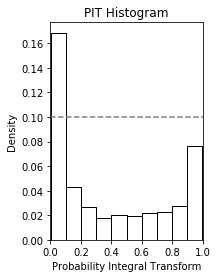

In [14]:
from ngboost.evaluation import *
y_dists = ngb.pred_dist(X_test)
pctles, observed, slope, intercept = calibration_regression(y_dists, y_test-min(y_test)+0.001)
plt.subplot(1, 2, 1)
plot_pit_histogram(pctles, observed, label="CRPS", linestyle = "-")


## **Feature importance**

Note: create a kernel with the requirements

https://github.com/stanfordmlgroup/ngboost/blob/master/examples/inspections/Feature%20importance.ipynb

In [18]:
ngb.feature_importances_[0] ## this does not work

AttributeError: 'NGBRegressor' object has no attribute 'feature_importances_'

In [15]:
feature_importance = pd.DataFrame({'feature':load_boston()['feature_names'], 
                                   'importance':ngb.feature_importances_[0]})\
    .sort_values('importance',ascending=False).reset_index().drop(columns='index')
fig, ax = plt.subplots()
plt.title('Feature Importance Plot')
sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance)

AttributeError: 'NGBRegressor' object has no attribute 'feature_importances_'

## **More explanability with shap values**

https://github.com/stanfordmlgroup/ngboost/blob/master/examples/inspections/SHAP%20plots.ipynb

In [ ]:
# see the probability distributions by visualising
Y_dists = ngb.pred_dist(X_val.drop(['SalePrice'],1))
y_range = np.linspace(min(X_val.SalePrice), max(X_val.SalePrice), 200)
dist_values = Y_dists.pdf(y_range).transpose()
# plot index 0 and 114
idx = 114
plt.plot(y_range,dist_values[idx])
plt.title(f"idx: {idx}")
plt.tight_layout()
plt.show()


In [22]:
dataset

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [ ]:
# see the probability distributions by visualising
Y_dists = ngb.pred_dist(dataset.drop(['SalePrice'],1))
y_range = np.linspace(min(X_val.SalePrice), max(X_val.SalePrice), 200)
dist_values = Y_dists.pdf(y_range).transpose()
# plot index 0 and 114
idx = 114
plt.plot(y_range,dist_values[idx])
plt.title(f"idx: {idx}")
plt.tight_layout()
plt.show()


## **Distribution**

In [ ]:
Y_dists.pdf(y_test.flatten())

In [ ]:
# see the probability distributions by visualising
Y_dists = ngb.pred_dist(X_test)
y_range = np.linspace(min(y_test), max(y_test), X_test.shape[0])
dist_values = Y_dists.pdf(y_range).transpose()

In [ ]:
import matplotlib.pyplot as plt
# plot index 0 and 114
idx = 4
plt.plot(y_range,dist_values[idx])
plt.title(f"idx: {idx}")
plt.tight_layout()
plt.show()

**References**

* NGBoost Explained [[here]](https://dkopczyk.quantee.co.uk/ngboost-explained/)


## **Other material to read**

* Dropout As a Bayesian Approximation: Representing Model Uncertainty in Deep Learning
https://arxiv.org/abs/1506.02142

* Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles
https://arxiv.org/abs/1612.01474